Train: (460, 8), Val: (154, 8), Test: (154, 8)
Epoch 0: Train Loss=0.4871, Val Loss=0.4494, Train Acc=0.7543, Val Acc=0.7532
Epoch 10: Train Loss=0.3583, Val Loss=0.4582, Train Acc=0.8391, Val Acc=0.7597
Epoch 20: Train Loss=0.2996, Val Loss=0.5108, Train Acc=0.8674, Val Acc=0.7597
Epoch 30: Train Loss=0.2419, Val Loss=0.5845, Train Acc=0.8848, Val Acc=0.7532
Epoch 40: Train Loss=0.1866, Val Loss=0.7244, Train Acc=0.9217, Val Acc=0.7208
Epoch 50: Train Loss=0.1450, Val Loss=0.8732, Train Acc=0.9435, Val Acc=0.7403
Epoch 60: Train Loss=0.1191, Val Loss=1.0739, Train Acc=0.9522, Val Acc=0.7208
Epoch 70: Train Loss=0.0936, Val Loss=1.2674, Train Acc=0.9696, Val Acc=0.6948
Epoch 80: Train Loss=0.0663, Val Loss=1.5058, Train Acc=0.9717, Val Acc=0.6818
Epoch 90: Train Loss=0.0792, Val Loss=1.7621, Train Acc=0.9717, Val Acc=0.7013

Rapport de classification (Test set) :
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       100
           1   

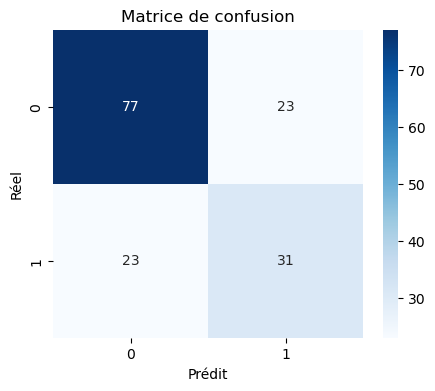

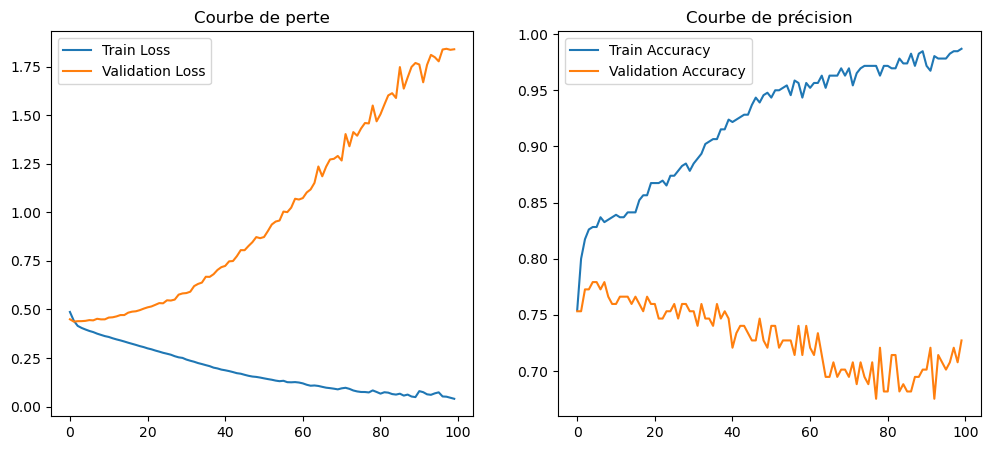

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Fonctions d'activation et dérivées
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

# Classe NeuralNetwork avec L2 et Adam
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, l2_lambda=0.0, optimizer='adam'):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.optimizer = optimizer
        self.weights = []
        self.biases = []
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)
        # Adam variables
        self.m_weights = [np.zeros_like(w) for w in self.weights]
        self.v_weights = [np.zeros_like(w) for w in self.weights]
        self.m_biases = [np.zeros_like(b) for b in self.biases]
        self.v_biases = [np.zeros_like(b) for b in self.biases]
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        a = X
        for i in range(len(self.weights) - 1):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            a = relu(z)
            self.activations.append(a)
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        self.z_values.append(z)
        a = sigmoid(z)
        self.activations.append(a)
        return a

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        # Binary cross-entropy
        loss = -np.mean(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))
        # L2 regularization
        l2_loss = 0
        if self.l2_lambda > 0:
            for w in self.weights:
                l2_loss += np.sum(np.square(w))
            l2_loss = (self.l2_lambda / (2 * m)) * l2_loss
        return loss + l2_loss

    def compute_accuracy(self, y_true, y_pred):
        preds = (y_pred >= 0.5).astype(int)
        return np.mean(preds == y_true)

    def backward(self, X, y, outputs):
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        # Output layer
        dZ = outputs - y
        self.d_weights[-1] = np.dot(self.activations[-2].T, dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        # L2 regularization
        if self.l2_lambda > 0:
            self.d_weights[-1] += (self.l2_lambda / m) * self.weights[-1]
        # Hidden layers
        da = dZ
        for l in range(len(self.weights) - 2, -1, -1):
            dz = np.dot(da, self.weights[l+1].T) * relu_derivative(self.z_values[l])
            self.d_weights[l] = np.dot(self.activations[l].T, dz) / m
            self.d_biases[l] = np.sum(dz, axis=0, keepdims=True) / m
            if self.l2_lambda > 0:
                self.d_weights[l] += (self.l2_lambda / m) * self.weights[l]
            da = dz

    def update_weights(self, t):
        if self.optimizer == 'adam':
            for i in range(len(self.weights)):
                # Adam update for weights
                self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * self.d_weights[i]
                self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (self.d_weights[i] ** 2)
                m_hat = self.m_weights[i] / (1 - self.beta1 ** t)
                v_hat = self.v_weights[i] / (1 - self.beta2 ** t)
                self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
                # Adam update for biases
                self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * self.d_biases[i]
                self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (self.d_biases[i] ** 2)
                m_hat_b = self.m_biases[i] / (1 - self.beta1 ** t)
                v_hat_b = self.v_biases[i] / (1 - self.beta2 ** t)
                self.biases[i] -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)
        else:  # SGD
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * self.d_weights[i]
                self.biases[i] -= self.learning_rate * self.d_biases[i]

    def train(self, X, y, X_val, y_val, epochs=100, batch_size=32):
        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
        m = X.shape[0]
        for epoch in range(epochs):
            indices = np.random.permutation(m)
            X_shuffled, y_shuffled = X[indices], y[indices]
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                outputs = self.forward(X_batch)
                self.backward(X_batch, y_batch, outputs)
                self.update_weights(epoch + 1)
            # Epoch metrics
            train_pred = self.forward(X)
            val_pred = self.forward(X_val)
            train_loss = self.compute_loss(y, train_pred)
            val_loss = self.compute_loss(y_val, val_pred)
            train_acc = self.compute_accuracy(y, train_pred)
            val_acc = self.compute_accuracy(y_val, val_pred)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        y_pred = self.forward(X)
        return (y_pred >= 0.5).astype(int)

# Préparation des données Pima Indians Diabetes
data = pd.read_csv("C:/Users/LUCEOM/Desktop/Master IAA/S2/diabetes.csv")
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zero:
    data[col] = data[col].replace(0, np.nan)
    data[col] = data[col].fillna(data[col].median())
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values.reshape(-1, 1)
# Standardisation
X = (X - X.mean(axis=0)) / X.std(axis=0)
# Split train/val/test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Architecture flexible
layer_sizes = [X_train.shape[1], 32, 16, 8, 1]  # Exemple d'architecture profonde
nn = NeuralNetwork(layer_sizes, learning_rate=0.01, l2_lambda=0.001, optimizer='adam')

# Entraînement
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(X_train, y_train, X_val, y_val, epochs=100, batch_size=32)

# Évaluation (Test)
y_pred = nn.predict(X_test)
print("\nRapport de classification (Test set) :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

# Courbes de perte et de précision
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.legend()
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Courbe de précision')
ax2.legend()
plt.show()
